# Intro to Time Series Modeling

- Conceptualize using steps in time as the features for a linear model
- Recognize mathematical notation for time steps/lag
- Perform a validation spliit on times series data
- List the differences between a one-step-ahead forecast and a dynamic forecast

## Intro

- This unit will cover using time patterns as a feature for predicting behavior.
- In previous lessons the idea of Linear Regression was covered, whereby different features had coefficients denoting their influence on the target. In the same way, time points can be considered features and used to predict future values.
    - To use time series data points as features in this way, the timepoints *MUST* be spaced evenly.

**Lags**
- Lags are the previous time points in a time series model. Each step backward represents another lag.
- If the target time is 'Yt', the previous time would be 'Yt-1', followed by 'Yt-2', etc.
- *Data must be constructed differently to use a linear regression for time series data, with each column being the value for the target from a previous time lag.*
- **True time series models will do this for us, but it will be demonstrated manually here to explain the concepts.**

**Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config
set_config(transform_output='pandas')
plt.rcParams['figure.figsize'] = (12, 4)
sns.set_context('talk', font_scale=0.9)

**Custom Functions**

In [5]:
def regression_metrics(y_true, y_pred, label='', verbose=True, output_dict=False):
    # Get metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False) 
    r_squared = r2_score(y_true, y_pred)
    if verbose == True:
        # Print Result with Label and Header
        header = "-"*60
        print(header, f"Regression Metrics: {label}", header, sep='\n')
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
    if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

In [6]:
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)
 
  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
  
  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index 
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

**Load Data**

In [8]:
# Import statsmodel base api module for the data
import statsmodels.api as sm
co2_data = sm.datasets.co2.load_pandas()
df = co2_data.data
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


## Visualizing Data and Exploring Model

**Visualizing Time Series**

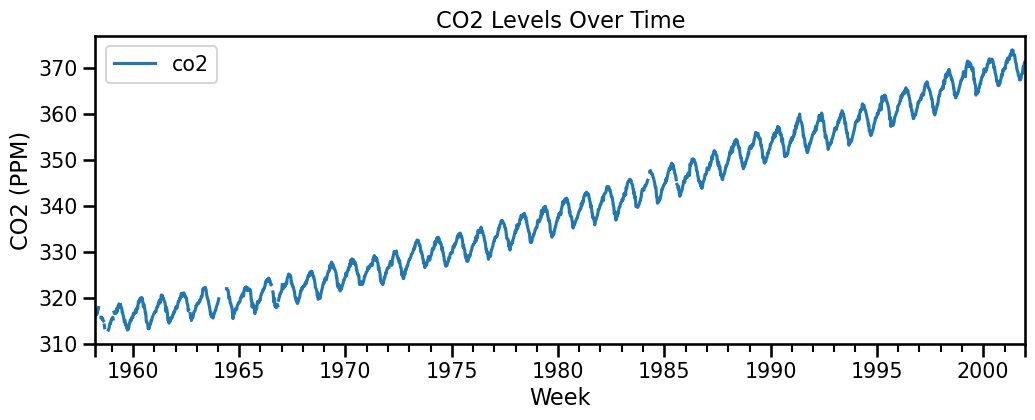

In [9]:
# Visualize the data
ax = df.plot()
ax.set(ylabel='CO2 (PPM)', xlabel='Week', title='CO2 Levels Over Time');

In [10]:
## The small gaps in data are likely null values
# Check for nulls
df.isna().sum()

co2    59
dtype: int64

In [11]:
# Address by imputing using interpolation
df = df.interpolate()
df.isna().sum()

co2    0
dtype: int64

**Create a t-1 column with .shift()**
- Manually create columns of data with lags. For the t-1 col, the data is essentially shifted by one row.
- Employ .shift() with a value of (1) to create a column representing a lag of 1.

In [12]:
# Add a col with the values from the previous week (one lag)
df['t-1'] = df['co2'].shift(1)
df.head()

,co2,t-1
1958-03-29,316.1,NaN
1958-04-05,317.3,316.1
1958-04-12,317.6,317.3
1958-04-19,317.5,317.6
1958-04-26,316.4,317.5


- Note how with a shift of 1 lag, the value for a row is now equal to the value one time period ago.
- Recreate this process for a total of 4 lags.

In [13]:
# Loop to add cols with lags 1-4
for i in range(1, 5):
    df[f't-{i}'] = df['co2'].shift(i)
df

,co2,t-1,t-2,t-3,t-4
1958-03-29,316.1,NaN,NaN,NaN,NaN
1958-04-05,317.3,316.1,NaN,NaN,NaN
1958-04-12,317.6,317.3,316.1,NaN,NaN
1958-04-19,317.5,317.6,317.3,316.1,NaN
1958-04-26,316.4,317.5,317.6,317.3,316.1
...,...,...,...,...,...
2001-12-01,370.3,370.3,369.7,368.8,368.7
2001-12-08,370.8,370.3,370.3,369.7,368.8
2001-12-15,371.2,370.8,370.3,370.3,369.7
2001-12-22,371.3,371.2,370.8,370.3,370.3


- When a row needs to access a timepoint that is 'n' lags behind, but there are not that many previous timepoints, it is simply assigned NaN.
- Because there are 4 lags required, the first 4 rows will not have enough previous data to be complete.

In [14]:
# Drop early rows with NaN values
df_model = df.dropna()
df_model

,co2,t-1,t-2,t-3,t-4
1958-04-26,316.4,317.5,317.6,317.3,316.1
1958-05-03,316.9,316.4,317.5,317.6,317.3
1958-05-10,317.2,316.9,316.4,317.5,317.6
1958-05-17,317.5,317.2,316.9,316.4,317.5
1958-05-24,317.9,317.5,317.2,316.9,316.4
...,...,...,...,...,...
2001-12-01,370.3,370.3,369.7,368.8,368.7
2001-12-08,370.8,370.3,370.3,369.7,368.8
2001-12-15,371.2,370.8,370.3,370.3,369.7
2001-12-22,371.3,371.2,370.8,370.3,370.3


## Linear Regression

**Prepare data for traditional Linear Regression**

In [16]:
# The target is co2, the actual value for that rows' date
y = df_model['co2']
X = df_model.drop(columns='co2')
X

,t-1,t-2,t-3,t-4
1958-04-26,317.5,317.6,317.3,316.1
1958-05-03,316.4,317.5,317.6,317.3
1958-05-10,316.9,316.4,317.5,317.6
1958-05-17,317.2,316.9,316.4,317.5
1958-05-24,317.5,317.2,316.9,316.4
...,...,...,...,...
2001-12-01,370.3,369.7,368.8,368.7
2001-12-08,370.3,370.3,369.7,368.8
2001-12-15,370.8,370.3,370.3,369.7
2001-12-22,371.2,370.8,370.3,370.3


**Validation Split for Time Series**
- Since the data set is organized based on time, it will not be a traditional train-test-split.
- Instead of using random 75/25 distribution, use the earliest 75% as training data and the remaining 25% as test data.
- Search for the index value representing 75% of the length of the dataset and round to a whole number.

In [17]:
# Calculate integer index for 75%/25% split
idx_split = round(len(X) * 0.75)
idx_split

1710

In [18]:
# Check index 1710
split_date = X.index[idx_split]
split_date

Timestamp('1991-02-02 00:00:00', freq='W-SAT')

- All dates from the beginning of the dataset to 1991-02-02 will be for training; the remainder are for testing.

In [19]:
## Time series train-test-split
# All data before split date is training
X_train = X.loc[:split_date]
y_train = y.loc[:split_date]
# All data after split date is testing
X_test = X.loc[split_date:]
y_test = y.loc[split_date:]

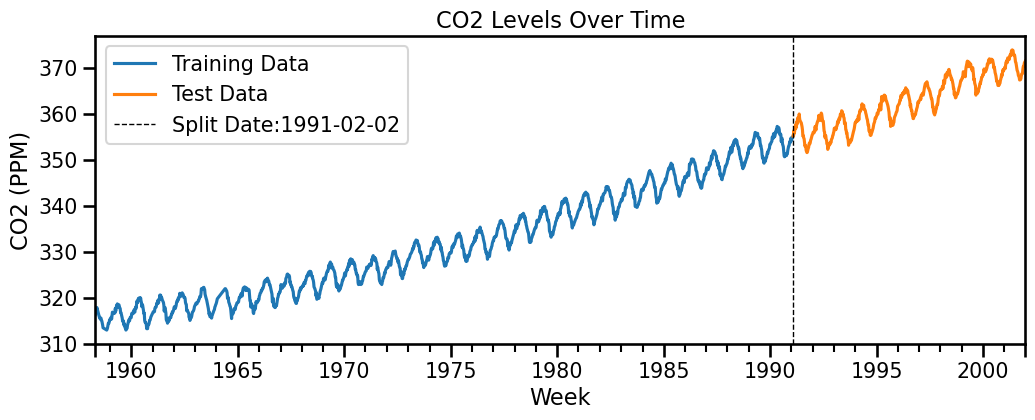

In [20]:
## Plot y_train and y_test to visualize result
# Plotting training and testing
ax = y_train.plot(label='Training Data')
y_test.plot(ax=ax, label='Test Data')
# Save the data asa string for matplotlib
split_date_str = split_date.strftime("%Y-%m-%d")
# Annotating the split data
ax.axvline(
    split_date_str, color='black', ls='--', lw=1, label=f'Split Date:{split_date_str}'
)
ax.set(ylabel='CO2 (PPM)', xlabel='Week', title='CO2 Levels Over Time')
ax.legend();

**Instantiate and Fit the Model**

In [21]:
# Instantiate a Lin Reg model
lin_reg = LinearRegression()
# Fit on the training data
lin_reg.fit(X_train, y_train)

LinearRegression()

**Obtain Predictions**

In [22]:
# Obtain the predictions and organize them into a Pandas Series
y_pred_test = lin_reg.predict(X_test)
y_pred_test = pd.Series(y_pred_test, index=y_test.index)
y_pred_test

1991-02-02    355.160974
1991-02-09    355.254278
1991-02-16    355.280741
1991-02-23    356.473156
1991-03-02    355.957149
                 ...    
2001-12-01    370.452759
2001-12-08    370.639149
2001-12-15    370.967720
2001-12-22    371.257917
2001-12-29    371.488852
Freq: W-SAT, Length: 570, dtype: float64

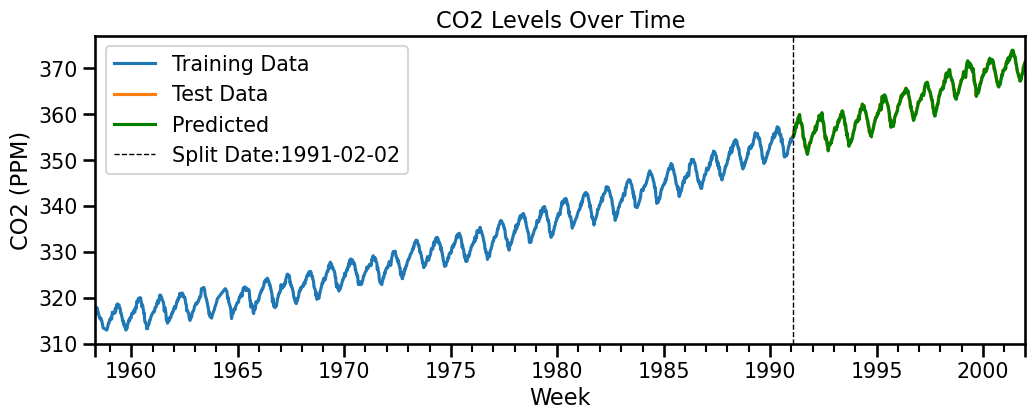

In [23]:
## Plot predictions along with training and test values
ax = y_train.plot(label='Training Data')
y_test.plot(ax=ax, label='Test Data')
y_pred_test.plot(ax=ax, label='Predicted', color='green')
# Saving the date as a string for matplotlib
split_date_str = split_date.strftime("%Y-%m-%d")
# Annotating the split data
ax.axvline(
    split_date_str, color='black', ls='--', lw=1, label=f"Split Date:{split_date_str}"
)
ax.set(ylabel='CO2 (PPM)', xlabel='Week', title='CO2 Levels Over Time')
ax.legend();

- This plot indicates the model was very close to the actual values, as the Test Data is completely obfuscated by the Predicted line.
- As this is a Lin Reg model, we can attain values for evaluating a model's fitness.

**Evaluate**

In [24]:
# Get predictions and metrics
evaluate_regression(lin_reg, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 0.344
- MSE = 0.198
- RMSE = 0.445
- R^2 = 0.999

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 0.381
- MSE = 0.239
- RMSE = 0.489
- R^2 = 0.992


**Predicting vs Forecasting**
- This model will predict only step into the future, and requires the four previous time points. This means it will never be able to predict more than 1 week into the future.
- To address this as 'dynamic forecast' must be used, making continued predictions based upon the models own previously predicted values.

## Summary

- This lesson introduced important concepts in time series modeling by demonstrating how time series data needs to be modified for use in a linear regression model.
- Time series models don't use typical features, instead relying on time lags.
- A validation split for a time series is not random, but uses the first 75% of data to train, and the final 25% to test.
- Finally, although this model can predict one step ahead, further lessons will explore using true time series models.

# Stationarity

- Define stationary data
- Identify white noise time series
- Use an AD Fuller test to determine if a time series is stationary

## Intro

- Many true time series models require the data to be 'stationary'.
- In order for data to be stationary it must:
    - Have a constant (stationary) mean (that is, the rolling mean doesn't change over time).
    - Have a constant (stationary) variance (the magnitude of the peaks/valleys does not change over time).
- To exhibit some of these concepts, White Noise Time Series will be examined below.

**White Noise Time Series**
- A white noise time series is a continuous time series of random values with a constant mean and constant variance. They are typically independently distributed and do not show autocorrelation.
- In other words, there is no overall trend or pattern to the values.
- An example will be constructed below.
    - This example is an additive white noise time series, where a mean value has another random coefficient added or subtracted to the value fresh at each time point.
    - Imagine a bus route that takes 49 minutes. Due to traffic, weather, etc., the route can be slightly longer or shorter.
    - Simulate running the route 120 times.

In [25]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import  statsmodels.tsa.api as tsa # new import
from sklearn import set_config
#set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk", font_scale=0.9)
# set random seed
SEED = 321
np.random.seed(SEED)

- Calculate the random change in route time for each day using Numpy's random.normal function, which selects a random value from a normal distribution. Then add this random value to the baseline of 49 to get the duration for that day.

In [27]:
## Use a loop to simulate 120 days
# Calculating a simulated white noise time series for 120 days
c = 49
n_lags = 120
y = []
for t in range(n_lags):
    noise_t = np.random.normal(size=1)
    y_t = c + noise_t[0] # Slice to get a value instead of array
    y.append(y_t)

In [29]:
# Now convert the list of values to a Pandas Series
ts_white_noise = pd.Series(y, name='Simulated White Noise')
ts_white_noise

0      47.880499
1      47.598865
2      47.532229
3      49.883495
4      48.147383
         ...    
115    51.250262
116    47.917365
117    49.353170
118    50.961444
119    49.713035
Name: Simulated White Noise, Length: 120, dtype: float64

**Plotting White Noise Time Series**
- Plotting can be especially helpful in understanding time series data. Below is a simple plot of the simulated time series created above.

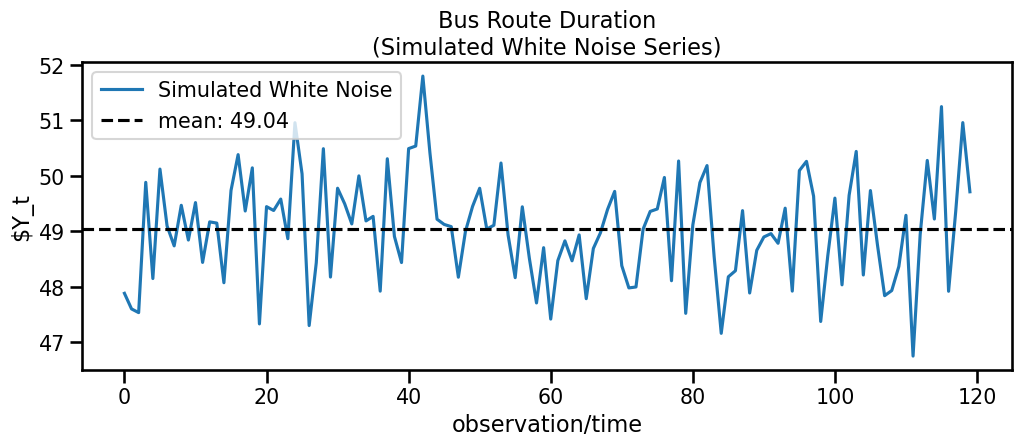

In [31]:
# Plotting the white noise series with annotated mean
ax = ts_white_noise.plot()
ax.set(title='Bus Route Duration\n(Simulated White Noise Series)',
       ylabel='$Y_t', xlabel='observation/time');
ax.axhline( ts_white_noise.mean(),  color='k', ls='--',
           label=f'mean: {ts_white_noise.mean():.2f}');
ax.legend();

- In this case a white noise time series was created just to demonstrate the qualities of one. In reality, an existing dataset would need to be examined to determine if it is stationary or not.
- Future topics will show how to confirm that a dataset is stationary.
    - It must be confirmed there is a constant mean and constant variance.
    - Rather than relying on visual estimation, there is a quantifiable test to use: the Augmented Dickey-Fuller Test.

**Augmented Dickey-Fuller Test**
- The Augmented Dickey-Fuller test returns many useful pieces of information:
    - adf (float): the test statistic
    - pvalue: the p-value (main stat of interest)
    - usedlag: The number of lags/time steps used
    - nobs: number of observations used
    - critical values (dict): Critical values for the test statistic at 1, 5, and 10% levels.
    - Some additional metrics

In [32]:
# Run the test on the white noise model
tsa.adfuller(ts_white_noise)

(-9.96665271601641,
 2.2975571736267382e-17,
 0,
 119,
 {'1%': -3.4865346059036564,
  '5%': -2.8861509858476264,
  '10%': -2.579896092790057},
 297.1841656525127)

- It returns the results as separate variables; save each output separately.

In [33]:
# Saving each output
(test_stat, pval, nlags, nobs, crit_vals_d, icbest) = tsa.adfuller(ts_white_noise)

In [34]:
# Select the most important results and include in a dictionary
adfuller_results = {'Test Statistic': test_stat,
                    '# of Lags Used': nlags,
                    '# of Observations': nobs,
                    'p-value': round(pval,6)}

- To aid interpretation, include an entry indicating whether or not the test had a significant p-value, and how this relates to stationarity.
- Here, define alpha as 0.05

In [35]:
# Add interpretation of p-value to dictionary
alpha = 0.05
adfuller_results['sig/stationary?'] = pval < alpha
adfuller_results

{'Test Statistic': -9.96665271601641,
 '# of Lags Used': 0,
 '# of Observations': 119,
 'p-value': 0.0,
 'sig/stationary?': True}

In [36]:
# Lastly, convert the dict to a dataframe
adfuller_df = pd.DataFrame(adfuller_results, index=['AD Fuller Test'])
adfuller_df

,Test Statistic,# of Lags Used,# of Observations,p-value,sig/stationary?
AD Fuller Test,-9.966653,0,119,0.0,True


- This cleaner output can indicate right away if a time series is stationary or not according to the ADF Test.
- Because this analysis will be repeated many times in future lesson work, it makes sense to save these steps to a function.
    - Allow options to change the alpha value, but set default to 0.05.
    - Include **kwargs so arguments can be modified if needed.

In [37]:
# Custom function for the ADFuller Test
def get_adfuller_results(ts, alpha=0.05, label='adfuller', **kwargs):
    # Save each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
     icbest) = tsa.adfuller(ts, **kwargs)
    # Convert output to dict with interpretation of p value
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index=[label])

In [38]:
# Test the custom function
adfuller_results = get_adfuller_results(ts_white_noise, label='White Noise')
adfuller_results

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
White Noise,-9.966653,0,119,0.0,0.05,True


## Summary

- This lesson covered the concept of stationarity. When working with time series models, it is necessary to determine if they are stationary or not.
- To be stationary, data must have a constant mean and constant variance.
- The ADFuller Test can be used to identify stationary datasets.
- The simplest stationary dataset is a White Noise dataset; White Noise is stationary and has no auto-correlation.

# Autocorrelation

- Determine if a dataset is autocorrelated
- Visualize and interpret autocorrelation plots
- Identify random walk time series
- Use differencing to transform a non-stationary dataset into a stationary one

## Intro to Autocorrelation

**What is autocorrelation?**
- In the machine learning unit, the topic of Pearson's `r` was covered, a value that shows how linearly coordinated two features are.
- Beacuse time series linear regression models use previous timepoints as the features, the correlation is with itself, hence auto-correlation.
- The white noise series created earlier should be entirely random and thus have no autocorrelation; test this hypothesis below.
- Before using the module's supplied test for detecting autocorrelation, one will be explored manually to demonstrate the concepts.

**Checking for Autocorrelation with 1 time lag**

In [39]:
# Shift the data one step
ts_lag1 = ts_white_noise.shift(1)
ts_lag1 = ts_lag1.rename('Lag 1')
ts_lag1.head()

0          NaN
1    47.880499
2    47.598865
3    47.532229
4    49.883495
Name: Lag 1, dtype: float64

In [40]:
# Combine this with the original values
ts_lagged = pd.concat([ts_white_noise, ts_lag1], axis=1)
ts_lagged.head()

,Simulated White Noise,Lag 1
0,47.880499,NaN
1,47.598865,47.880499
2,47.532229,47.598865
3,49.883495,47.532229
4,48.147383,49.883495


In [41]:
# Check for a correlation between the original value and the first lag
ts_lagged.corr()

,Simulated White Noise,Lag 1
Simulated White Noise,1.000000,0.086168
Lag 1,0.086168,1.000000


- Autocorrelation is at almost zero for Lag 1, which is expected with a random series.
- To really test for autocorrelation though, more than 1 timepoint will be needed.

**Checking for Autocorrelation with many time lags**

In [42]:
# Use a loop to create columns for time lags 0-20 (note lag 0 is just the original value)
ts_lagged = pd.DataFrame()
total_shifts = 20
for t in range(0, total_shifts+1):
    ts_lagged[f"Lag {t}"] = ts_white_noise.shift(t)
ts_lagged.head()

,Lag 0,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,...,Lag 11,Lag 12,Lag 13,Lag 14,Lag 15,Lag 16,Lag 17,Lag 18,Lag 19,Lag 20
0,47.880499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,47.598865,47.880499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,47.532229,47.598865,47.880499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,49.883495,47.532229,47.598865,47.880499,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48.147383,49.883495,47.532229,47.598865,47.880499,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Calculate the correlation matrix for all values in the df
corr = ts_lagged.corr()
corr.head()

,Lag 0,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,...,Lag 11,Lag 12,Lag 13,Lag 14,Lag 15,Lag 16,Lag 17,Lag 18,Lag 19,Lag 20
Lag 0,1.000000,0.086168,0.037990,0.078414,-0.054383,0.041048,-0.040807,0.079838,-0.005542,0.038451,...,-0.163813,0.098066,0.172723,-0.103117,0.010011,-0.175062,-0.037114,0.005525,0.104633,-0.046138
Lag 1,0.086168,1.000000,0.075679,0.035979,0.085896,-0.070352,0.039739,-0.049716,0.080357,0.009552,...,0.128104,-0.157716,0.107310,0.175201,-0.108490,0.015780,-0.187437,-0.041857,0.012901,0.100763
Lag 2,0.037990,0.075679,1.000000,0.070812,0.057452,0.046555,-0.075897,0.015709,-0.049601,0.129955,...,0.050645,0.153772,-0.137192,0.115471,0.164429,-0.093691,-0.013557,-0.204838,-0.021261,0.000653
Lag 3,0.078414,0.035979,0.070812,1.000000,0.074760,0.051853,0.045919,-0.080652,0.015881,-0.043511,...,0.006231,0.054677,0.159110,-0.136326,0.113483,0.167970,-0.099698,-0.015712,-0.202683,-0.023417
Lag 4,-0.054383,0.085896,0.057452,0.074760,1.000000,0.101922,0.054668,0.061628,-0.081800,-0.010923,...,0.122468,-0.007033,0.040795,0.156642,-0.128983,0.104396,0.188813,-0.092697,-0.028692,-0.197131


- For autocorrelation, we are specifically interested in how other lags correlate to the target value, so we will slice out only that, Lag 0.

In [44]:
# Slice out original ts
auto_corr = corr['Lag 0']
auto_corr

Lag 0     1.000000
Lag 1     0.086168
Lag 2     0.037990
Lag 3     0.078414
Lag 4    -0.054383
Lag 5     0.041048
Lag 6    -0.040807
Lag 7     0.079838
Lag 8    -0.005542
Lag 9     0.038451
Lag 10    0.123156
Lag 11   -0.163813
Lag 12    0.098066
Lag 13    0.172723
Lag 14   -0.103117
Lag 15    0.010011
Lag 16   -0.175062
Lag 17   -0.037114
Lag 18    0.005525
Lag 19    0.104633
Lag 20   -0.046138
Name: Lag 0, dtype: float64

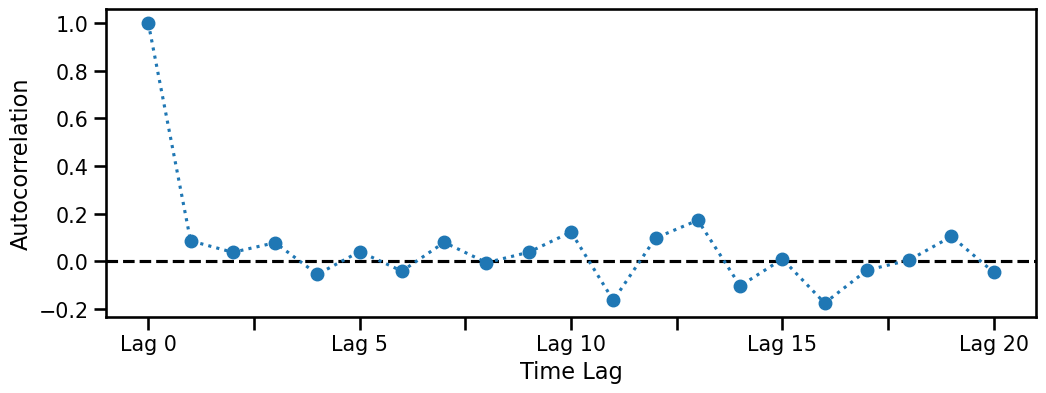

In [46]:
# Plot the correlation values to aid in interpretation
ax = auto_corr.plot(style='o:')
ax.axhline(0, color='k', ls='--', zorder=-1);
ax.set(ylabel='Autocorrelation', xlabel='Time Lag');

- Correlation in this model is right around zero, exactly where it should be for a stationary White Noise time series.

## Statsmodels `plot_acf`

- Try visually check for autocorrelation using .plot_acf
- Simply include the original time series as the arg when calling the fucntion, and it will produce an ACF plot.

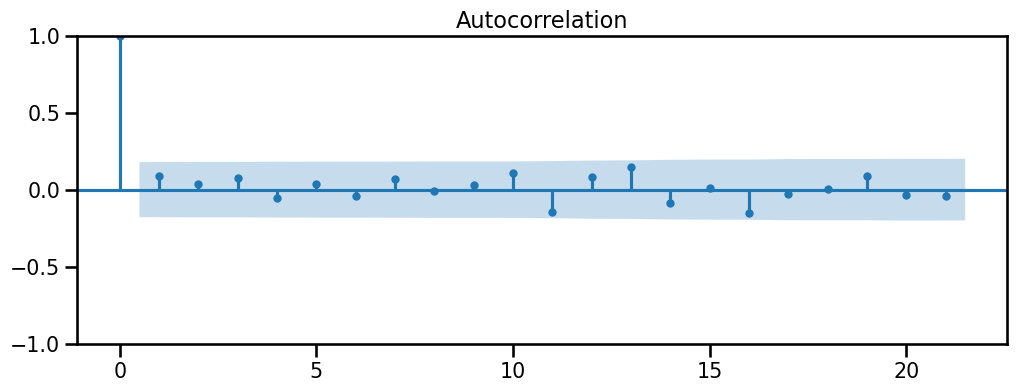

In [48]:
fig = tsa.graphics.plot_acf(ts_white_noise);

- Although the plot looks different stylistically, it displays the same information at the line plot above.
- As long as the values stay mostly within the shaded region, it is safe to conclude there is *no* autocorrelation.
- Between the ADFuller Test and the ACF Plot, it is possible to confirm that a time series if indeed stationary with no autocorrelation (which further confirms it as a White Noise Time Series).

## Random Walk Time Series

- In contrast to White Noise is a Random Walk time series. Random walks:
    - Are Not stationary
    - Have significant autocorrelation
    - Differencing a random walk creates a white noise time series
- Instead of generating a new value at each time point that is the result of the mean plus a random number, a Random Walk instead uses the value from the previous timepoint, then adds a random number.

In [49]:
# Create a random walk starting with an arbitrary value of 150
first_t = 150
y_walk = [first_t]
n_lags = 120
for t in range(1, n_lags):
    # Get previous time lag's value
    y_prev_t = y_walk[t-1]
    # Get new noise
    noise_t = np.random.normal(size=1)
    # Add noise to previous value
    y_t = y_prev_t + noise_t[0] # slice 0 to get value instead of array
    y_walk.append(y_t)

ts_rand_walk = pd.Series(y_walk, name='Simulated Random Walk')
ts_rand_walk

0      150.000000
1      150.571668
2      150.029815
3      149.697119
4      149.316326
          ...    
115    146.629277
116    148.157668
117    149.046836
118    149.146191
119    148.554525
Name: Simulated Random Walk, Length: 120, dtype: float64

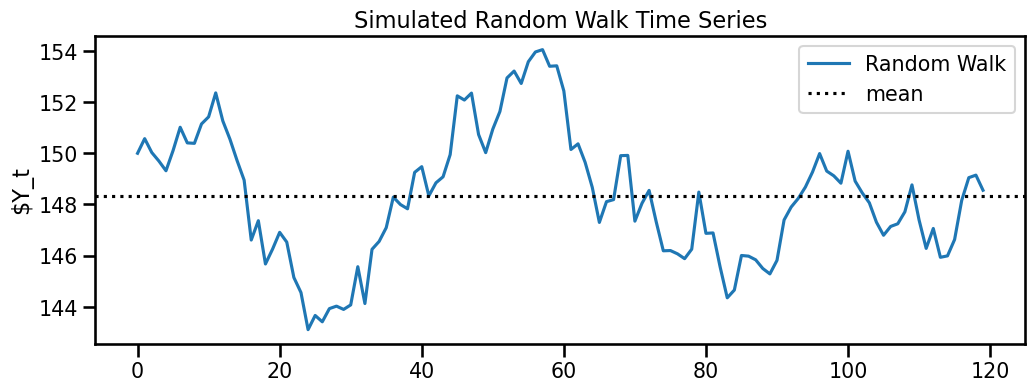

In [50]:
# Now visualize the random walk series
ax = ts_rand_walk.plot(label='Random Walk')
ax.set(ylabel='$Y_t', title='Simulated Random Walk Time Series');
ax.axhline(ts_rand_walk.mean(), color='black', ls=':', label='mean');
ax.legend();

**Check for Stationarity with ADFuller Test**

In [51]:
# Test random walk for stationarity
get_adfuller_results(ts_rand_walk)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-2.090234,0,119,0.24846,0.05,False


- As expected, the random walk is NOT stationary.

**Create ACF Plot for Random Walk**

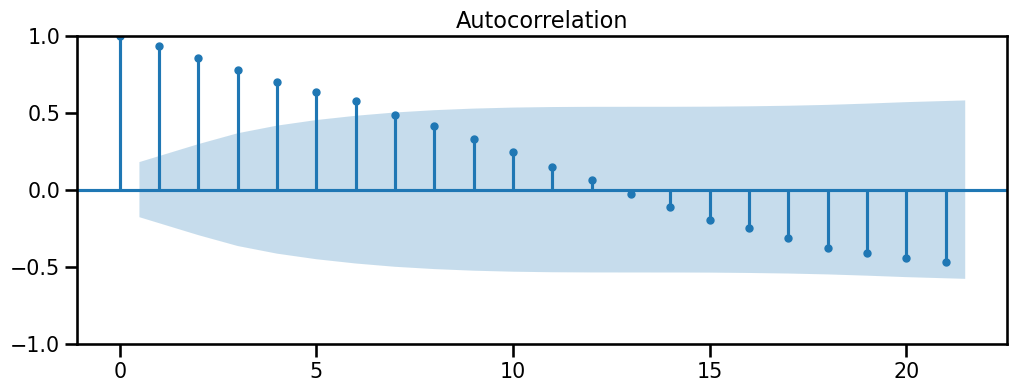

In [52]:
# Check for autocorrelation
tsa.graphics.plot_acf(ts_rand_walk);

- Note the difference between this ACF Plot and the one created for white noise above. In this plot, there are many values outside the shaded area (significant values).

**Differencing**
- To difference a time series is to subtract the previous value from each time lag.
- If differencing a random walk, the result will be the leftover random fluctuation.

In [53]:
# Original random walk
ts_rand_walk.head()

0    150.000000
1    150.571668
2    150.029815
3    149.697119
4    149.316326
Name: Simulated Random Walk, dtype: float64

In [55]:
# Differenced random walk
ts_rand_walk.diff().head()

0         NaN
1    0.571668
2   -0.541853
3   -0.332696
4   -0.380793
Name: Simulated Random Walk, dtype: float64

- The resultant values are those that were added to each lag.
- Verify this with the previous tests.

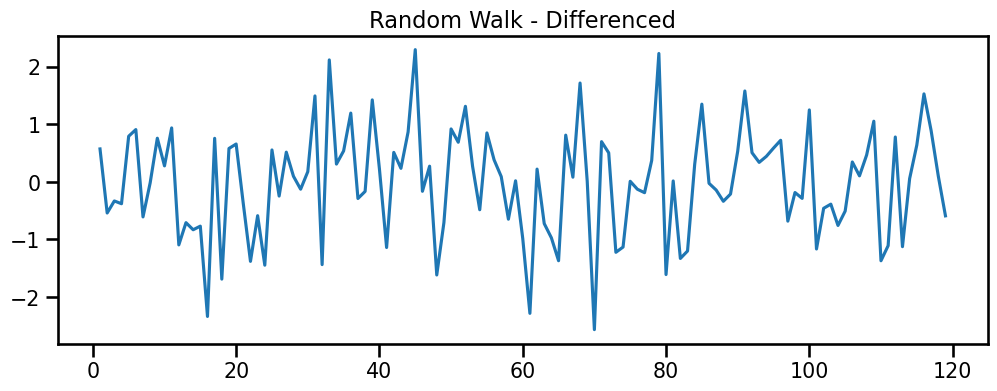

In [56]:
# Plot differenced random walk
ts_rand_walk_diff = ts_rand_walk.diff().dropna()
ts_rand_walk_diff.plot(title='Random Walk - Differenced');

**Check stationarity with ADFuller**

In [57]:
# Check differenced random walk for stationarity
get_adfuller_results(ts_rand_walk_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-10.45481,0,118,0.0,0.05,True


**Check for autocorrelation with ACF Plot**

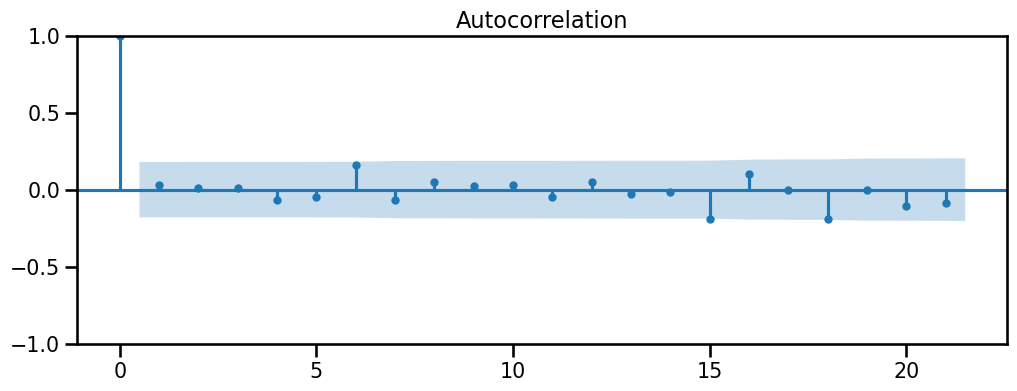

In [58]:
# Check differenced random walk for autocorrelation
tsa.graphics.plot_acf(ts_rand_walk_diff);

- Differencing has removed the autocorrelation from the random walk.

## Random Walk with a Drift

- Random walk with a drift models are like random walks in that they are the previous value added to a random value.
- However, they also contain another variable, a Drift variable, that pushed the trend in a specific direction.
- Random Walks with a Drift:
    - Are NOT stationary
    - Have significant autocorrelation
    - Have a constant trend (increase or descrease)
    - Differencing a random walk with a drift creates a stationary time series.

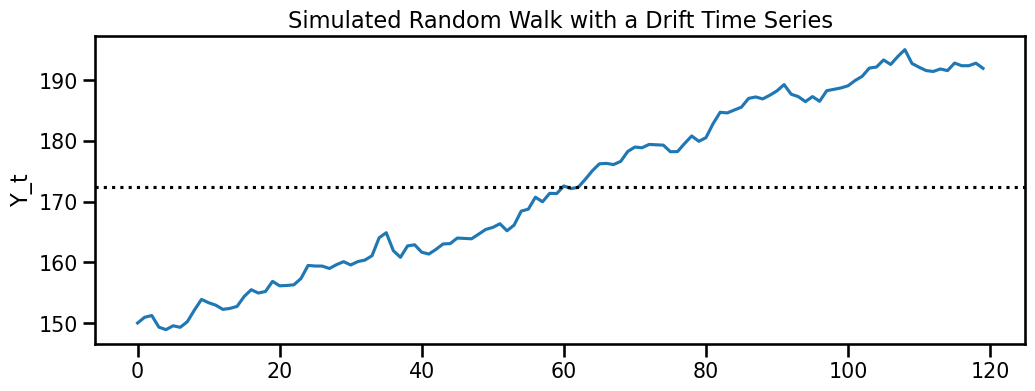

In [61]:
# Create a simulated random walk with a drift of 0.3
first_t = 150
c = .3
y_walk_drift = [first_t]
for t in range(1,n_lags):
    # get the previous time lag's value
    y_prev_t = y_walk_drift[t-1]
    
    # Get new noise
    noise_t = np.random.normal(size=1)
    # Add noise on to previous value
    y_t = c + y_prev_t + noise_t[0]# slicing 0 to get value instead of arrays
    y_walk_drift.append(y_t)
    
ts_rand_walk_drift = pd.Series(y_walk_drift, name = "Simulated Random walk (+dift)")    
ax = ts_rand_walk_drift.plot()
ax.set(ylabel='Y_t', title='Simulated Random Walk with a Drift Time Series');
ax.axhline(ts_rand_walk_drift.mean(), color='black', ls=':');

- For comparison, plot the random walk and the random walk with a drift

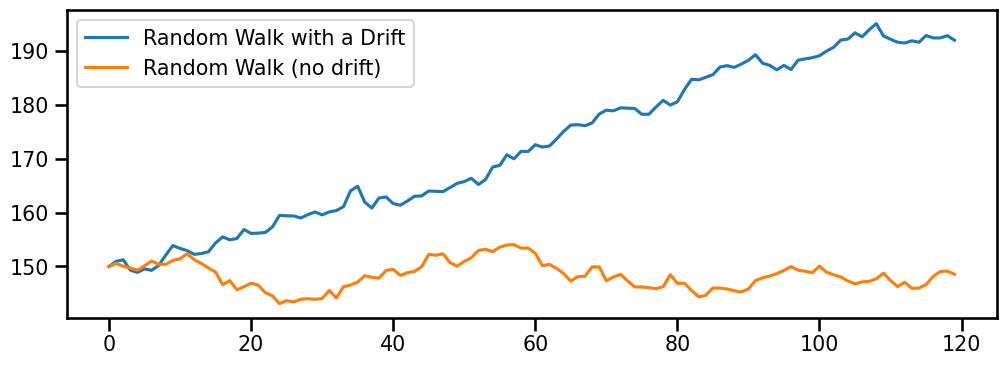

In [62]:
# Compare random walk with a drift vs without
ax = ts_rand_walk_drift.plot(label='Random Walk with a Drift')
ts_rand_walk.plot(ax=ax, label='Random Walk (no drift)')
ax.legend();

**Checking for stationarity with ADFuller**

In [63]:
# Test random walk with a drift for stationarity
get_adfuller_results(ts_rand_walk_drift)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-0.657282,2,117,0.857506,0.05,False


**Checking for autocorrelation with ACF Plot**

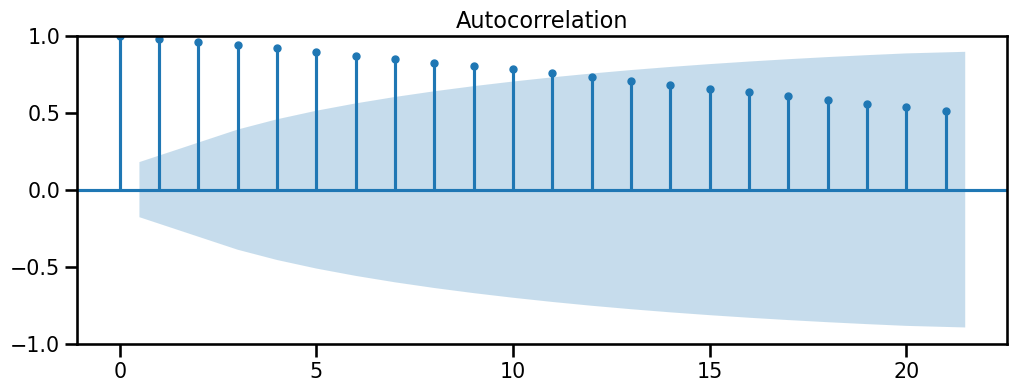

In [64]:
# Test random walk a with a drift for autocorrelation
tsa.graphics.plot_acf(ts_rand_walk_drift);

**Differencing**

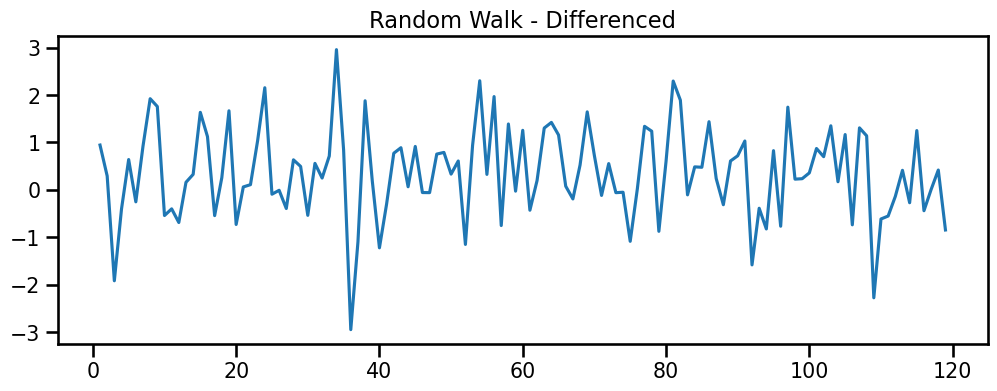

In [65]:
# Difference the random walk with a drift
ts_rand_walk_drift_diff = ts_rand_walk_drift.diff().dropna()
# Visualize the differenced random walk with a drift
ts_rand_walk_drift_diff.plot(title='Random Walk - Differenced');

**Checking diff values for stationarity with ADFuller Test**
- Confirm the differenced random walk with a drift is now stationary

In [68]:
# Confirm that a differenced random walk with drift is stationary
get_adfuller_results(ts_rand_walk_drift_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-9.142995,1,117,0.0,0.05,True


**Check diff values for autocorrelation with ACF Plot**

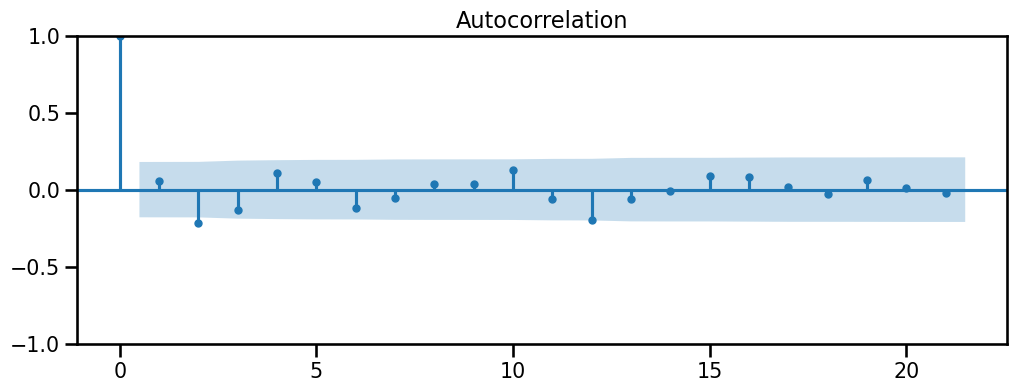

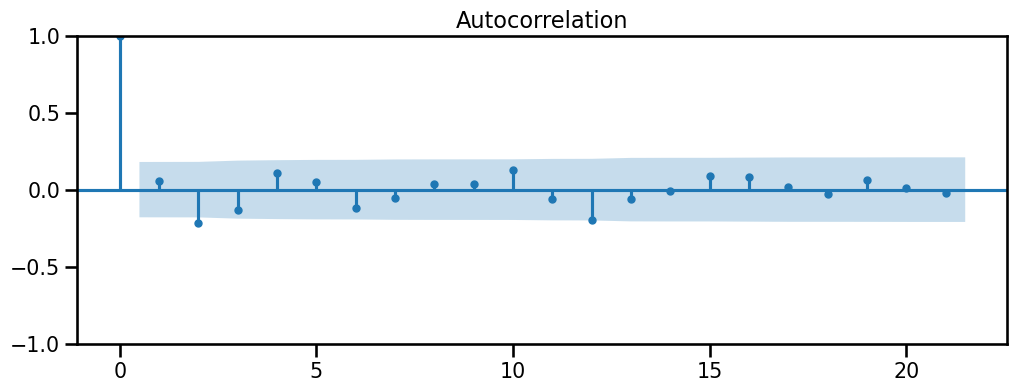

In [69]:
# Check the differenced random walk with drift for autocorrelation
tsa.graphics.plot_acf(ts_rand_walk_drift_diff)

## Summary

- This lesson introduced the concept of autocorrelation in time series data.
- This occurs when there is correlation between a feature and one or more previous time lags.
- Autocorrelation can be tested for by using an ACF Plot.
- Random walks:
    - Are not stationary, and have significant autocorrelation.
    - With a drift means it includes a drift component in the calculation of new values.
    - Become stationary after differencing.
-  When exploring a time series:
    -  Plot the time series
    -  Check for Stationarity with ADFuller Test
    -  Check for Autocorrelationn with ACF Plot

**Note**: Applying differencing with 1 time lag will almost always turn a non-stationary time series into a stationary one.